The __Official__ Colab Demo for ICCV'21 paper

__[Dressing in Order: Recurrent Person Image Generation for Pose Transfer, Virtual Try-on and Outfit Editing](https://arxiv.org/abs/2104.07021)__


\[[Code](https://github.com/cuiaiyu/dressing-in-order)\]
\[[Paper](https://arxiv.org/abs/2104.07021)\]

# Read Before Starting
- This Colab Demo is available for __non-commercial research purposes__ only.
- This Colab contains data downloading scripts. __*Please make sure you are legally allowed to use the [DeepFahsion-MultiModal dataset](https://github.com/yumingj/DeepFashion-MultiModal) as required by [their license]() before trying this demo.*__


# Step 0: Install Environment
(This demo only supports inference, so we don't install GFLA.)

In [1]:
# check GPU
# If you don't have GPU, please set it by Runtime -> Change runtime type
!nvidia-smi

Thu Dec 14 19:25:16 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.29                 Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce MX450         WDDM  | 00000000:2B:00.0 Off |                  N/A |
| N/A   59C    P0              N/A / ERR! |      0MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Step 1: Download Data
This Data is from [DeepFashion-Multimodal](https://arxiv.org/abs/2205.15996) [1].

Please make sure you read [the dataset license](https://github.com/yumingj/DeepFashion-MultiModal/blob/main/LICENSE) before running the below code.

You are __responsible__ to make sure whether the data is available for your usage.

```[1] Jiang, Yuming, et al. "Text2human: Text-driven controllable human image generation." ACM Transactions on Graphics (TOG) 41.4 (2022): 1-11.```



In [17]:
os.getcwd()

'd:\\Vietnam Datathon\\try_again_dior\\dressing-in-order'

In [11]:
# download data from https://github.com/yumingj/DeepFashion-MultiModal
import os
from tqdm.notebook import tqdm

if not os.path.exists("data"):
  os.system("mkdir data")

def download_from_gdrive(dst_root, fn, gdrive_path, iszip=True):
  if not os.path.exists(dst_root):
    os.system("mkdir {}".format(dst_root))
  if not os.path.exists("{}/{}".format(dst_root, fn)):
    os.system("gdown {}".format(gdrive_path))
    if iszip:
      os.system("unzip {}.zip".format(fn))
      os.system("rm {}.zip".format(fn))
    os.system("mv {} {}/".format(fn, dst_root))
  print("download {}.".format(fn))

# # download data
# download_from_gdrive("data", "testM_lip", "1toeQwAe57LNPTy9EWGG0u1XfTI7qv6b1")
# download_from_gdrive("data", "images", "1U2PljA7NE57jcSSzPs21ZurdIPXdYZtN")
# download_from_gdrive("data","fasion-pairs-test.csv","12fZKGf0kIu5OX3mjC-C3tptxrD8sxm7x",iszip=False)
# download_from_gdrive("data","fasion-annotation-test.csv","1MxkVFFtNsWFshQp_TA7qwIGEUEUIpYdS",iszip=False)
# download_from_gdrive("data","standard_test_anns.txt","19nJSHrQuoJZ-6cSl3WEYlhQv6ZsAYG-X",iszip=False)

# # filter images (exclude training data and rename the files)
# if not os.path.exists("data"):
#   os.mkdir("data/test")
# target_fns = [fn[:-4] for fn in os.listdir("data/testM_lip")]
# for fn in tqdm(os.listdir("data/images")):
#   elements = fn.split("-")
#   elements[2] = elements[2].replace("_","")
#   last_elements = elements[-1].split("_")
#   elements[-1] = last_elements[0] + "_" + last_elements[1] + last_elements[2]
#   new_fn = "fashion"+"".join(elements)

#   if new_fn[:-4] in target_fns:
#     os.system("mv {} {}".format("data/images/"+fn, "data/test/"+new_fn))



# Step 2: Load Pre-trained Model

In [6]:
import torch
from models.dior_model import DIORModel
import os, json
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
dataroot = 'data'
exp_name = 'DIORv1_64' # DIOR_64
epoch = 'latest'
netG = 'diorv1' # dior
ngf = 64

## this is a dummy "argparse"
class Opt:
    def __init__(self):
        pass
if True:
    opt = Opt()
    opt.dataroot = dataroot
    opt.isTrain = False
    opt.phase = 'test'
    opt.n_human_parts = 8; opt.n_kpts = 18; opt.style_nc = 64
    opt.n_style_blocks = 4; opt.netG = netG; opt.netE = 'adgan'
    opt.ngf = ngf
    opt.norm_type = 'instance'; opt.relu_type = 'leakyrelu'
    opt.init_type = 'orthogonal'; opt.init_gain = 0.02; opt.gpu_ids = [0]
    opt.frozen_flownet = True; opt.random_rate = 1; opt.perturb = False; opt.warmup=False
    opt.name = exp_name
    opt.vgg_path = ''; opt.flownet_path = ''
    opt.checkpoints_dir = 'checkpoints'
    opt.frozen_enc = True
    opt.load_iter = 0
    opt.epoch = epoch
    opt.verbose = False

# create model
#os.mkdir("checkpoints")
# download_from_gdrive("checkpoints", "DIORv1_64", "1MyHq-P0c8zz7ey7p_HTTZKeMie5ZuNlb")

model = DIORModel(opt)
model.setup(opt)


d:\Vietnam Datathon\try_again_dior\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Vietnam Datathon\try_again_dior\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


load vgg ckpt from torchvision dict.
[init] init pre-trained model vgg.
initialize network with orthogonal
initialize network with orthogonal
initialize network with kaiming
initialize network with orthogonal
[init] frozen net netVGG.
[init] frozen net netFlow.
[init] frozen net netE_attr.
[init] frozen net netE_attr.
loading the model from checkpoints\DIORv1_64\latest_net_E_attr.pth
loading the model from checkpoints\DIORv1_64\latest_net_G.pth
not exsits checkpoints\DIORv1_64\latest_net_VGG.pth
loading the model from checkpoints\DIORv1_64\latest_net_Flow.pth
---------- Networks initialized -------------
[Network E_attr] Total number of parameters : 1.191 M
[Network G] Total number of parameters : 16.501 M
[Network VGG] Total number of parameters : 0.113 M
[Network Flow] Total number of parameters : 6.608 M
-----------------------------------------------
[tensorboard] init tensorboard @ checkpoints\DIORv1_64\test


-1

In [4]:
# load data
from datasets.deepfashion_datasets import DFVisualDataset
Dataset = DFVisualDataset
ds = Dataset(dataroot=dataroot, dim=(256,176), n_human_part=8)

# # preload a set of pre-selected models defined in "standard_test_anns.txt" for quick visualizations
# inputs = dict()
# for attr in ds.attr_keys:
#     inputs[attr] = ds.get_attr_visual_input(attr)

# define some tool functions for I/O
def load_img(pid, ds):
    if len(pid[0]) < 10: # load pre-selected models
        person = inputs[pid[0]]
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
        pimg, parse, to_pose = pimg[pid[1]], parse[pid[1]], to_pose[pid[1]]
    else: # load model from scratch
        person = ds.get_inputs_by_key(pid[0])
        person = (i.cuda() for i in person)
        pimg, parse, to_pose = person
    return pimg.squeeze(), parse.squeeze(), to_pose.squeeze()

def plot_img(pimg=[], gimgs=[], oimgs=[], gen_img=[], pose=None):
    if pose != None:
        import utils.pose_utils as pose_utils
        # print(pose.size())
        kpt = pose_utils.draw_pose_from_map(pose.cpu().numpy().transpose(1,2,0),radius=6)
        kpt = kpt[0]
    if not isinstance(pimg, list):
        pimg = [pimg]
    if not isinstance(gen_img, list):
        gen_img = [gen_img]
    out = pimg + gimgs + oimgs + gen_img
    if out:
        out = torch.cat(out, 2).float().cpu().detach().numpy()
        out = (out + 1) / 2 # denormalize
        out = np.transpose(out, [1,2,0])

        if pose != None:
            out = np.concatenate((kpt, out),1)
    else:
        out = kpt
    fig = plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
    plt.axis('off')
    plt.imshow(out)

# define dressing-in-order function (the pipeline)
def dress_in_order(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2], perturb=False):
    PID = [0,4,6,7]
    GID = [2,5,1,3]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if perturb:
        pimg = perturb_images(pimg[None])[0]
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])


    # swap base garment if any
    gimgs = []
    for gid in gids:
        _,_,k = gid
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg * (gparse == gid[2])]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs += [oimg * (oparse == gid[2])]
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, gimgs, oimgs, gen_img[0], to_pose



# Applications

NOTE: INDEX OF GARMENT is used as following:

- 'top':5, # dress is also considered as top.
- 'bottom':1,
- 'hair':2,
- 'jacket':3


## Pose Transfer

In [14]:
from PIL import Image

# Open the image file
img = Image.open('./data/testM_lip/pant_test.png')

# Convert the image to 'P' mode
img_p = img.convert('P')

# Save the converted image
img_p.save('./data/testM_lip/pant_test.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


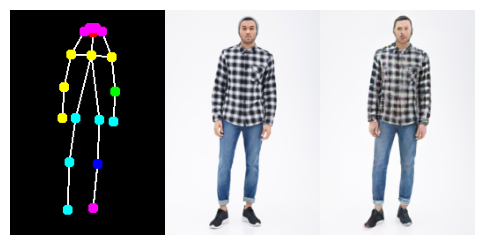

In [7]:
import numpy as np
%matplotlib inline
# person id
pid = ("test_image_1.jpg", None, None) # load the 0-th person from "print" group, NONE (no) garment is interested
# pose id (take this person's pose)
pose_id = ("test_image_1.jpg", None, None) # load the 2-nd person from "print" group, NONE (no) garment is interested
# generate
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, pose_id=pose_id)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Virtual Try-On (Tucking in/out)

Users can control the tuck-in and tuck-out results when there is overlap between the top garment and the bottom garment.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


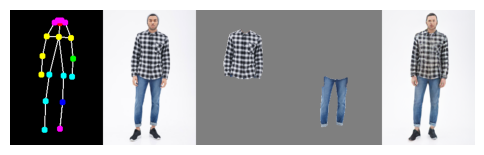

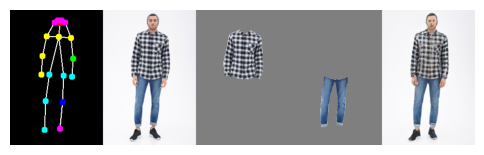

In [8]:
pid = ("test_image_1.jpg", None, None) # load the 3-rd person from "pattern" group, NONE (no) garment is interested
gids = [
   ("test_image_1.jpg",0,5), # load the 0-th person from "plaid" group, garment #5 (top) is interested
   ("test_image_1.jpg",3,1),  # load the 3-rd person from "pattern" group, garment #1 (bottom) is interested
       ]

# tuck in (dressing order: hair, top, bottom)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,5,1])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)

# not tuckin (dressing order: hair, bottom, top)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids, order=[2,1,5])
plot_img(pimg, gimgs, gen_img=gen_img, pose=pose)



## Virtual Try-On (Layering)


d:\Vietnam Datathon\try_again_dior\venv\Lib\site-packages\torch\nn\functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


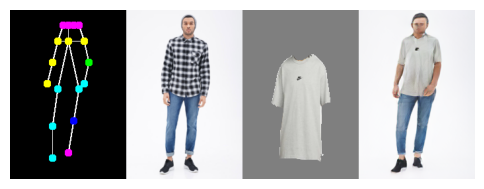

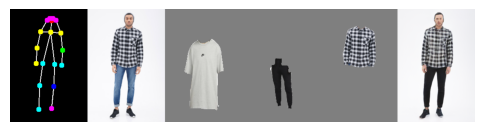

In [9]:
pid = ('test_image_1.jpg',None, None)
gids = [('garment_nike.jpg', None, 5)]
# tuck in
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)


pid = ('fashionMENDenimid0000056501_7additional.jpg',None, None)

gids = [('garment_nike.jpg', None, 5),
        ('pant_test_2.jpg', None, 1)
        
        ]
# Dùng để multi lyaer 
ogids = [
 ('fashionMENDenimid0000056501_7additional.jpg', None ,5),
]
# tuck in
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid, gids=gids , ogids = ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Virual Try-On (Layering - Muliple)


torch.Size([18, 256, 176])


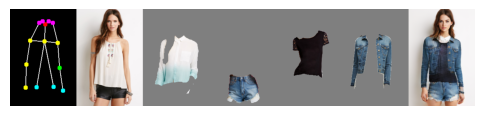

In [ ]:
# person id
pid = ("fashionWOMENBlouses_Shirtsid0000637003_1front.jpg", None , None) # load person from the file

# garments to try on (ordered)
gids = [
    ("gfla",2,5),
    ("strip",3,1),
       ]

# garments to lay over (ordered)
ogids = [
 ("fashionWOMENTees_Tanksid0000159006_1front.jpg", None ,5),
 ('fashionWOMENJackets_Coatsid0000645302_1front.jpg', None ,3),
]

# dressing in order
pimg, gimgs, oimgs, gen_img, pose = dress_in_order(model, pid=pid, gids=gids, ogids=ogids)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Opacity

(-0.5, 1231.5, 255.5, -0.5)

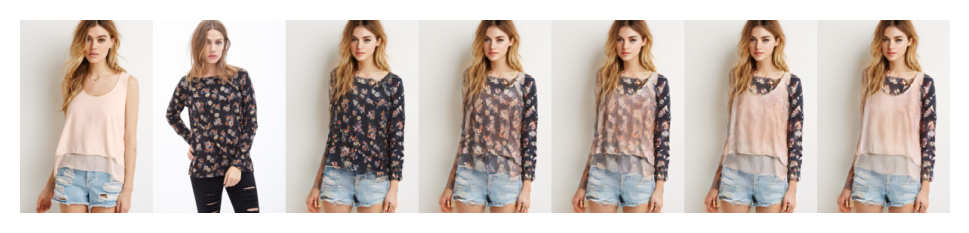

In [ ]:

def dress_in_order_opcaity(model, pid, pose_id=None, gids=[], ogids=[], order=[5,1,3,2]):
    PID = [0,4,6,7]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    if not pose_id:
        to_pose = from_pose
    else:
        to_img, _, to_pose = load_img(pose_id, ds)
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])

    # swap base garment if any
    gimgs = []
    for gid in gids:
        gimg, gparse, pose =  load_img(gid, ds)
        seg = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=gid[2])
        gsegs[gid[2]] = seg
        gimgs += [gimg]

    # encode garment (overlay)
    garments = []
    over_gsegs = []
    oimgs = []
    for gid in ogids:
        oimg, oparse, pose = load_img(gid, ds)
        oimgs.append(oimg)
        seg = model.encode_single_attr(oimg[None], oparse[None], pose[None], to_pose[None], i=gid[2])
        over_gsegs += [seg]

    gsegs = [gsegs[i] for i in order] + over_gsegs
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    gmap, mask = gsegs[-1]
    gens = []
    for alpha in [0, 0.99, 0.6, 0.35, 0.25]:
        curr_mask = mask.clone() # * alpha
        curr_mask[curr_mask >= alpha] = alpha
        gsegs[-1] = gmap, curr_mask
        img = model.netG(to_pose[None], psegs, gsegs, alpha=0.1999)
        gens.append(img[0])
    return pimg, gimgs, oimgs, gens, to_pose

pid = ('fashionWOMENBlouses_Shirtsid0000270306_1front.jpg', None, 5)
gids = [('fashionWOMENTees_Tanksid0000255303_1front.jpg', None, 5)]
ogids = [('fashionWOMENBlouses_Shirtsid0000270306_1front.jpg', None, 5)]

pimg, gimgs, oimgs, gens, to_pose = dress_in_order_opcaity(model, pid=pid, gids=gids, ogids=ogids)

# plot results: (source person, source garment-inside, transparency results)
output = torch.cat([pimg, gimgs[0],gens[0]] + gens[::-1][:-1], 2)
output = (output + 1) / 2
output = output.float().cpu().detach().numpy()
output = np.transpose(output, [1,2,0])
fig=plt.figure(figsize=(6,4), dpi= 200, facecolor='w', edgecolor='k')
plt.imshow(output)
plt.axis('off')

## Reshaping


In [ ]:

def dress_in_order_texshape(model, pid, target=5, shape_id=None, tex_patch=None, order=[2,5,1,3]):
    PID = [0,4,6,7]
    # encode person
    pimg, parse, from_pose = load_img(pid, ds)
    to_pose = from_pose
    psegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None], PID)

    # encode base garments
    gsegs = model.encode_attr(pimg[None], parse[None], from_pose[None], to_pose[None])

    fmap, mask = gsegs[target]
    gimg = pimg*(parse==target)
    if shape_id != None:
        gimg, gparse, pose =  load_img(shape_id, ds)
        _, mask = model.encode_single_attr(gimg[None], gparse[None], pose[None], to_pose[None], i=target)
        shape_img = [gimg*(gparse==target)]
    else:
        shape_img = []
    if tex_patch != None:
        fmap = model.netE_attr(tex_patch, model.netVGG)
    gsegs[target] = fmap, mask
    gsegs = [gsegs[i] for i in order]
    gen_img = model.netG(to_pose[None], psegs, gsegs)

    return pimg, [gimg], shape_img, gen_img[0], to_pose

torch.Size([18, 256, 176])


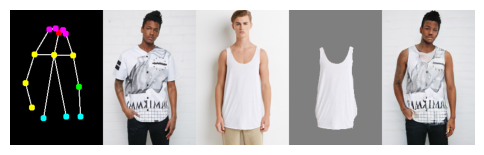

In [ ]:
pid = ('print', 0, 5)
shape_id = ('plain', 2, 5)

pimg, gimgs, oimgs, gen_img, pose = dress_in_order_texshape(model, pid, shape_id=shape_id)
plot_img(pimg, gimgs, oimgs, gen_img, pose)

## Texture Transfer

torch.Size([18, 256, 176])


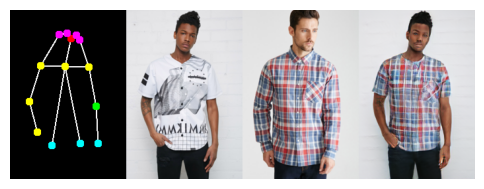

In [ ]:

pid = ('print', 0, 5)
patch_id = ('plaid', 0, 5)
patch, parse, from_pose = load_img(patch_id, ds)
pimg, gimgs, oimgs, gen_img, pose = dress_in_order_texshape(model, pid, tex_patch=patch[None])
plot_img(pimg, [patch], oimgs, gen_img, pose)


## Print Insertion (RGBA image required)


download doge.png.


d:\Vietnam Datathon\try_again_dior\venv\Lib\site-packages\torch\nn\functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


(-0.5, 527.5, 255.5, -0.5)

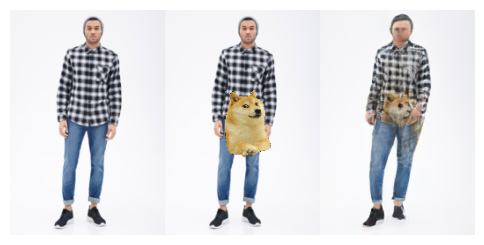

In [15]:
# download from https://www.stickpng.com/img/memes/doge/doge-facing-right
import cv2
download_from_gdrive("data","doge.png","1ZjEZVWGyLX7Mefrkc03uaEsspP0Nk_EL",iszip=False)

fn = "data/doge.png"
pid = ('test_image_1.jpg', None, None)

image = cv2.imread(fn, cv2.IMREAD_UNCHANGED) #Read RGBA image
# put the print on a blank canvas
x,y,h,w = 90,60,80,70
image = cv2.resize(image, (w,h))
bg = np.zeros((256,176,4))
bg[x:x+h,y:y+w] = image
image = bg

# crop the print image
trans_mask = image[:,:,3] != 0
image = image[:,:,2::-1].transpose(2,0,1)
image = (image / 255.0) * 2 - 1
image = image * trans_mask[None]


# run DiOr
pimg, parse, to_pose =  load_img(pid, ds)
psegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [0,4,6,7])
gsegs = model.encode_attr(pimg[None], parse[None], to_pose[None], to_pose[None], [5,1,2])
# insert the print
print_image = torch.from_numpy(image).float().cuda()
print_fmap = model.netE_attr(print_image[None], model.netVGG)
print_mask = model.netE_attr.module.segmentor(print_fmap)
gsegs = gsegs[:1] + [(print_fmap, torch.sigmoid(print_mask))] + gsegs[1:]
# generate
gen_img = model.netG(to_pose[None], psegs, gsegs)

# construct a copy-and-paste image for comparison
paste_img = image + pimg.cpu().detach().numpy() * (1 - trans_mask[None])
paste_img = torch.from_numpy(paste_img).float().cuda()

# display
output = torch.cat([pimg, paste_img, gen_img[0]],2)
output = output.float().cpu().detach().numpy()
output = (output + 1) / 2
output = np.transpose((output * 255.0).astype(np.uint8), [1,2,0])
fig=plt.figure(figsize=(6,4), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(output)
plt.axis('off')